In [69]:
import numpy as np
from tifffile import imread, imsave, TiffFile

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from scipy.ndimage.morphology import distance_transform_edt
import itk
from skimage.morphology import remove_small_objects, dilation, disk
from skimage.filters import threshold_otsu
from skimage.measure import label
from aicssegmentation.core.visual import blob2dExplorer_single, fila2dExplorer_single, random_colormap
from aicssegmentation.core.seg_dot import dot_2d, logSlice
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, suggest_normalization_param, edge_preserving_smoothing_3d

## load one example image

In [70]:
# this is timelapse images, we want to know how many time steps we have in each image
fn = './UNC_PCNA/161013 rpe #7 ncs survival_added drugNCS_10_1c1.tif'
tif = TiffFile(fn)

In [71]:
# it is okay if you see an error like invalid page offset, it does not hurt when loading the image
num_img = len(tif.pages)
print(num_img)

TiffPages: invalid page offset 782838210


24


In [72]:
img_seq = []
for ii in range(num_img):
    img_seq.append(imread(fn, key=ii))

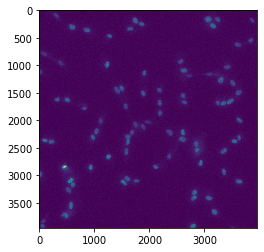

In [73]:
plt.imshow(img_seq[8])

## crop a small area for algorithm development

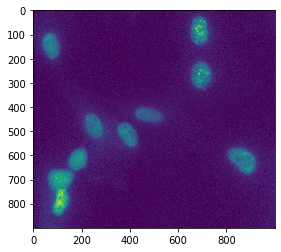

In [74]:
img = img_seq[8][1600:2500,1500:2500]
plt.imshow(img)

## pre-processing: intensity normalization and smoothing

In [75]:
suggest_normalization_param(img)

mean intensity of the stack: 97.80359444444444
the standard deviation of intensity of the stack: 145.88766893809455
0.9999 percentile of the stack intensity is: 1247.0
minimum intensity of the stack: 0
maximum intensity of the stack: 1435
suggested upper range is 8.0, which is 1264.9049459492007
suggested lower range is 0.5, which is 24.859759975397168
So, suggested parameter for normalization is [0.5, 8.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [76]:
img_norm = intensity_normalization(img, [0.5, 8.0])

intensity normalization: normalize into [mean - 0.5 x std, mean + 8.0 x std] 
intensity normalization completes


In [77]:
img_smooth = edge_preserving_smoothing_3d(img_norm)

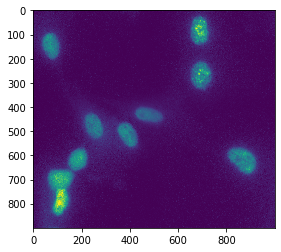

In [78]:
plt.imshow(img_smooth)

# try blob detection

In [79]:
interact(blob2dExplorer_single, im=fixed(img_smooth), \
         sigma=widgets.FloatRangeSlider(value=(1,5), min=1, max=15,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.02,min=0.01, max=0.1, step=0.01,continuous_update=False));

interactive(children=(FloatRangeSlider(value=(1.0, 5.0), continuous_update=False, description='sigma', max=15.…

## apply the optimal parameters found in previous step

In [80]:
nuc_detection = dot_2d(img_smooth, 11)

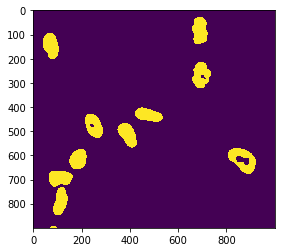

In [81]:
nuc_mask = nuc_detection>0.02
plt.imshow(nuc_mask)

## refine the results

In [82]:
final_seg = hole_filling(remove_small_objects(nuc_mask),1, 1600)

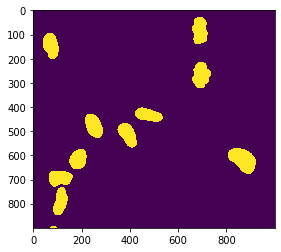

In [83]:
plt.imshow(final_seg)

## detect the punta in PCNA

In [84]:
interact(blob2dExplorer_single, im=fixed(img_smooth), \
         sigma=widgets.FloatRangeSlider(value=(1,3), min=1, max=10,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.02,min=0.01, max=0.07, step=0.01,continuous_update=False));

interactive(children=(FloatRangeSlider(value=(1.0, 3.0), continuous_update=False, description='sigma', max=10.…

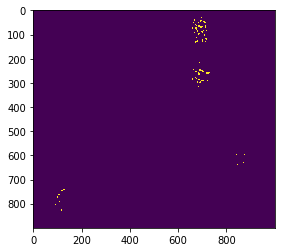

In [85]:
puncta = logSlice(img_smooth,[2.0,3.0], 0.05)
plt.imshow(puncta)

## get the puncta of each individual cell

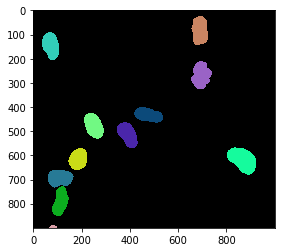

In [86]:
nuc_label = dilation(label(final_seg), disk(3))
plt.imshow(nuc_label, random_colormap())

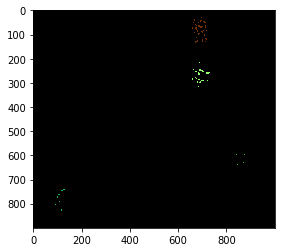

In [87]:
puncta = puncta.astype(np.uint16)
puncta[puncta>0]=1
puncta_group = nuc_label.astype(np.uint16) * puncta
plt.imshow(puncta_group, random_colormap())